In [1]:
import pandas as pd

from collections import defaultdict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Imputer, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, SelectPercentile
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
import numpy as np
import itertools
import seaborn
from sklearn.metrics import roc_auc_score
from experiments.libs import loaders
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [87]:
loaders.load_iot??

In [84]:
df.head()

,rcdminutes,temperature,humidity,light,voltage,class
0,58.0,19.7336,37.0933,71.76,2.69964,19
1,58.0,19.6160,37.5737,97.52,2.69964,25
2,58.0,19.7728,37.1620,143.52,2.71196,24
3,58.0,20.2040,36.8871,50.60,2.69964,3
4,58.0,20.4196,36.6118,121.44,2.65143,6


In [90]:
df['rcdminutes'].value_counts().sort_index()

0.0       1516
1.0       1571
2.0       1525
3.0       1609
4.0       1532
5.0       1572
6.0       1524
7.0       1510
8.0       1558
9.0       1527
10.0      1578
11.0      1534
12.0      1513
13.0      1553
14.0      1568
15.0      1507
16.0      1565
17.0      1535
18.0      1554
19.0      1522
20.0      1550
21.0      1527
22.0      1524
23.0      1569
24.0      1536
25.0      1516
26.0      1548
27.0      1483
28.0      1524
29.0      1540
          ... 
1410.0    1498
1411.0    1548
1412.0    1551
1413.0    1594
1414.0    1506
1415.0    1588
1416.0    1510
1417.0    1568
1418.0    1538
1419.0    1521
1420.0    1541
1421.0    1535
1422.0    1572
1423.0    1534
1424.0    1585
1425.0    1533
1426.0    1560
1427.0    1529
1428.0    1562
1429.0    1568
1430.0    1571
1431.0    1551
1432.0    1580
1433.0    1546
1434.0    1572
1435.0    1541
1436.0    1567
1437.0    1561
1438.0    1564
1439.0    1576
Name: rcdminutes, dtype: int64

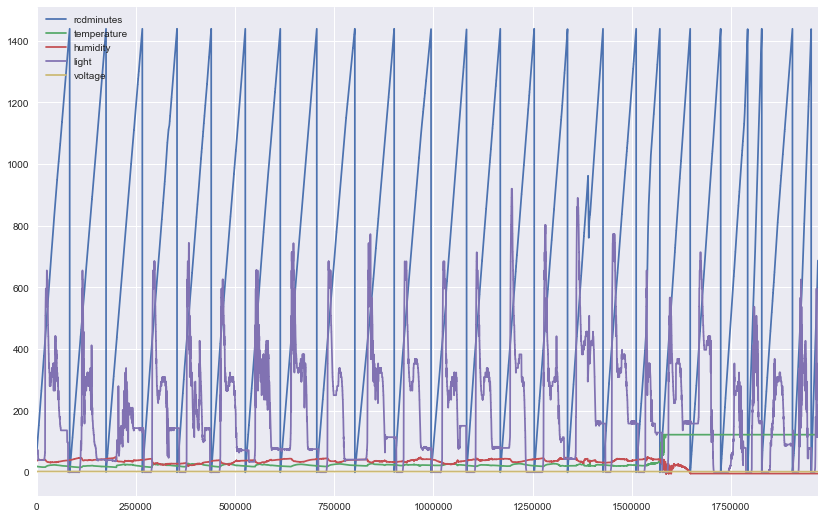

In [79]:
df[df['class']=='19'].plot(figsize=(14, 9))

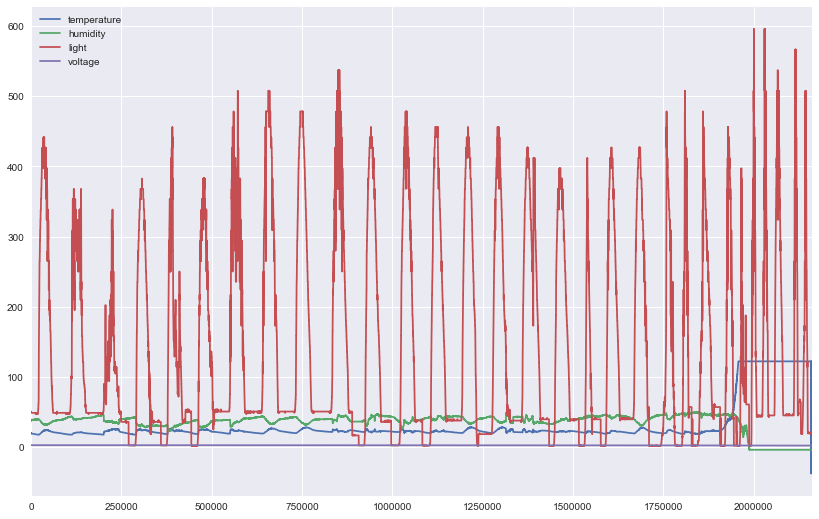

In [92]:
df[df['class']=='3'][['temperature', 'humidity', 'light', 'voltage']].plot(figsize=(14, 9))

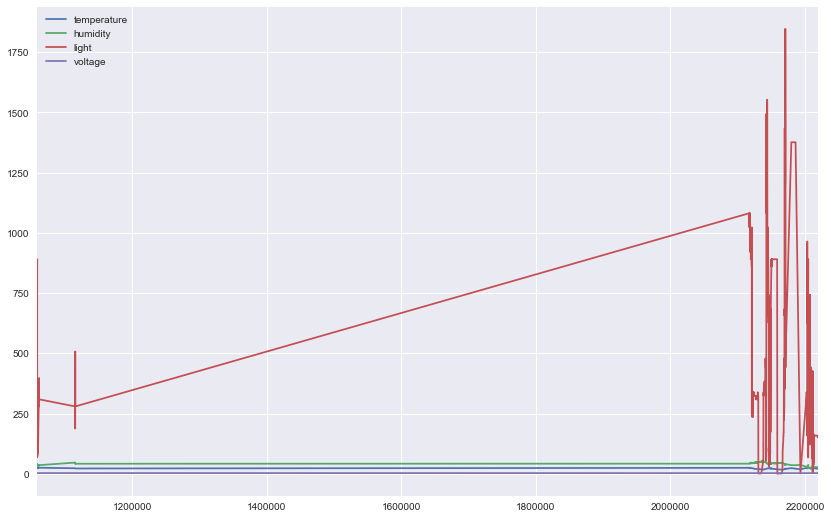

In [102]:
df[df['class']=='55'][['temperature', 'humidity', 'light', 'voltage']].plot(figsize=(14, 9))

In [4]:
def create_column_selector(columns):
    def selector(df, y=None, **kwargs):
        return df.xs(columns, axis=1, **kwargs)
    return selector

In [93]:
continuous_feature_columns = ['rcdminutes', 'temperature', 'humidity', 'light', 'voltage']

In [94]:
pipeline_steps = [('select_columns', FunctionTransformer(create_column_selector(continuous_feature_columns), 
                                                                                validate=False, 
                                                                                pass_y=False)),
                  ('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [95]:
featurisers = [('continuous', continuous_pipeline)]

In [96]:
classification_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier())]) 

In [97]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [98]:
%%time
cv_results = cross_val_score(classification_pipeline, df, df['class'], cv=cv, scoring='accuracy')
cv_results

CPU times: user 7h 8min 2s, sys: 28min 54s, total: 7h 36min 57s
Wall time: 25min 1s


In [99]:
cv_results

array([ 0.28542276,  0.28564131,  0.28502135])

In [25]:
%connect_info

{
  "shell_port": 36162,
  "iopub_port": 58765,
  "stdin_port": 60242,
  "control_port": 59043,
  "hb_port": 58493,
  "ip": "127.0.0.1",
  "key": "fa428715-d177-4b32-8087-0ae23aaa82f0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-637cec66-8934-4f73-948f-c763e7b445a4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [12]:
predictions = cross_val_predict(classification_pipeline, df, df['class'], cv=cv)

In [13]:
predictions.shape

(2219803,)

In [14]:
cmp_df=pd.DataFrame({'class':df['class'],
                     'prediction':predictions})

In [15]:
confusion_matrix = cmp_df.groupby('class').apply(lambda x: x['prediction'].value_counts()).unstack()

,1,10,11,12,13,14,15,16,17,18,...,52,53,54,55,56,58,6,7,8,9
class,,,,,,,,,,,,,,,,,,,,,
1,12065.0,546.0,442.0,NaN,NaN,91.0,NaN,13.0,391.0,1223.0,...,284.0,139.0,NaN,17.0,NaN,NaN,246.0,1336.0,162.0,568.0
10,219.0,9786.0,1679.0,6.0,153.0,595.0,NaN,306.0,548.0,1170.0,...,373.0,820.0,28.0,1.0,NaN,NaN,37.0,1633.0,73.0,31.0
11,102.0,331.0,12892.0,70.0,932.0,245.0,5.0,394.0,793.0,848.0,...,144.0,134.0,273.0,NaN,NaN,NaN,891.0,208.0,74.0,928.0
12,372.0,192.0,517.0,3014.0,64.0,31.0,NaN,844.0,94.0,35.0,...,36.0,113.0,908.0,7.0,NaN,NaN,162.0,139.0,147.0,967.0
13,94.0,964.0,2753.0,777.0,3350.0,40.0,NaN,287.0,408.0,145.0,...,124.0,116.0,309.0,NaN,NaN,NaN,605.0,205.0,95.0,29.0
14,331.0,82.0,89.0,23.0,7.0,2212.0,NaN,54.0,18.0,1262.0,...,154.0,84.0,295.0,8.0,NaN,NaN,14.0,722.0,325.0,697.0
15,NaN,1.0,90.0,NaN,NaN,NaN,81.0,31.0,3.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3.0,NaN,95.0
16,988.0,389.0,416.0,282.0,159.0,13.0,NaN,12815.0,422.0,278.0,...,300.0,35.0,272.0,1.0,NaN,NaN,288.0,98.0,66.0,1806.0
17,818.0,504.0,1254.0,NaN,79.0,44.0,NaN,57.0,7614.0,825.0,...,40.0,6.0,1031.0,1.0,NaN,NaN,807.0,129.0,8.0,2.0


In [30]:
confusion_matrix.index = confusion_matrix.index.astype(int)
confusion_matrix.columns = confusion_matrix.columns.astype(int)

In [34]:
confusion_matrix = confusion_matrix.sort_index().sort_index(axis=1)

In [49]:
confusion_matrix

,1,2,3,4,6,7,8,9,10,11,...,48,49,50,51,52,53,54,55,56,58
class,,,,,,,,,,,,,,,,,,,,,
1,12065.0,1110.0,2819.0,240.0,246.0,1336.0,162.0,568.0,546.0,442.0,...,492.0,12.0,NaN,921.0,284.0,139.0,NaN,17.0,NaN,NaN
2,672.0,12677.0,1737.0,182.0,152.0,3241.0,132.0,88.0,164.0,188.0,...,139.0,16.0,NaN,311.0,486.0,274.0,NaN,NaN,NaN,NaN
3,4485.0,1449.0,10311.0,630.0,70.0,883.0,105.0,68.0,207.0,1812.0,...,16.0,NaN,NaN,316.0,653.0,33.0,NaN,20.0,NaN,NaN
4,390.0,1248.0,319.0,3455.0,41.0,981.0,166.0,384.0,1614.0,219.0,...,7.0,NaN,NaN,35.0,852.0,16.0,NaN,NaN,NaN,NaN
6,62.0,655.0,108.0,479.0,10088.0,1863.0,1150.0,221.0,201.0,872.0,...,331.0,249.0,NaN,133.0,151.0,26.0,16.0,NaN,NaN,NaN
7,234.0,942.0,395.0,167.0,119.0,10614.0,473.0,588.0,224.0,142.0,...,815.0,NaN,NaN,1370.0,242.0,385.0,NaN,11.0,NaN,NaN
8,24.0,70.0,161.0,4.0,115.0,163.0,4282.0,1737.0,41.0,221.0,...,791.0,80.0,27.0,113.0,13.0,17.0,239.0,43.0,NaN,NaN
9,64.0,147.0,70.0,46.0,228.0,270.0,40.0,25129.0,64.0,627.0,...,254.0,160.0,1.0,146.0,53.0,48.0,277.0,44.0,61.0,5.0
10,219.0,1304.0,512.0,920.0,37.0,1633.0,73.0,31.0,9786.0,1679.0,...,871.0,97.0,NaN,2892.0,373.0,820.0,28.0,1.0,NaN,NaN


In [48]:
df['class'].value_counts().sort_index().head()

1     43047
10    47155
11    41833
12    19016
13    27013
Name: class, dtype: int64

In [47]:
confusion_matrix.sum(axis=0).head()

1    43668.0
2    58062.0
3    40309.0
4    17956.0
6    25760.0
dtype: float64

In [56]:
cm_percent = confusion_matrix.div(confusion_matrix.sum(axis=0), axis=0)
cm_percent

,1,2,3,4,6,7,8,9,10,11,...,48,49,50,51,52,53,54,55,56,58
class,,,,,,,,,,,,,,,,,,,,,
1,0.276289,0.025419,0.064555,0.005496,0.005633,0.030594,0.003710,0.013007,0.012503,0.010122,...,0.011267,0.000275,NaN,0.021091,0.006504,0.003183,NaN,0.000389,NaN,NaN
2,0.011574,0.218336,0.029916,0.003135,0.002618,0.055820,0.002273,0.001516,0.002825,0.003238,...,0.002394,0.000276,NaN,0.005356,0.008370,0.004719,NaN,NaN,NaN,NaN
3,0.111265,0.035947,0.255799,0.015629,0.001737,0.021906,0.002605,0.001687,0.005135,0.044953,...,0.000397,NaN,NaN,0.007839,0.016200,0.000819,NaN,0.000496,NaN,NaN
4,0.021720,0.069503,0.017766,0.192415,0.002283,0.054634,0.009245,0.021386,0.089886,0.012196,...,0.000390,NaN,NaN,0.001949,0.047449,0.000891,NaN,NaN,NaN,NaN
6,0.002407,0.025427,0.004193,0.018595,0.391615,0.072321,0.044643,0.008579,0.007803,0.033851,...,0.012849,0.009666,NaN,0.005163,0.005862,0.001009,0.000621,NaN,NaN,NaN
7,0.004997,0.020118,0.008436,0.003567,0.002541,0.226679,0.010102,0.012558,0.004784,0.003033,...,0.017406,NaN,NaN,0.029258,0.005168,0.008222,NaN,0.000235,NaN,NaN
8,0.001269,0.003702,0.008515,0.000212,0.006082,0.008621,0.226477,0.091871,0.002169,0.011689,...,0.041836,0.004231,0.001428,0.005977,0.000688,0.000899,0.012641,0.002274,NaN,NaN
9,0.001265,0.002907,0.001384,0.000910,0.004508,0.005339,0.000791,0.496886,0.001265,0.012398,...,0.005022,0.003164,0.000020,0.002887,0.001048,0.000949,0.005477,0.000870,0.001206,0.000099
10,0.007583,0.045149,0.017727,0.031854,0.001281,0.056540,0.002528,0.001073,0.338827,0.058133,...,0.030157,0.003358,NaN,0.100132,0.012915,0.028391,0.000969,0.000035,NaN,NaN


In [21]:
from matplotlib import pyplot as plt

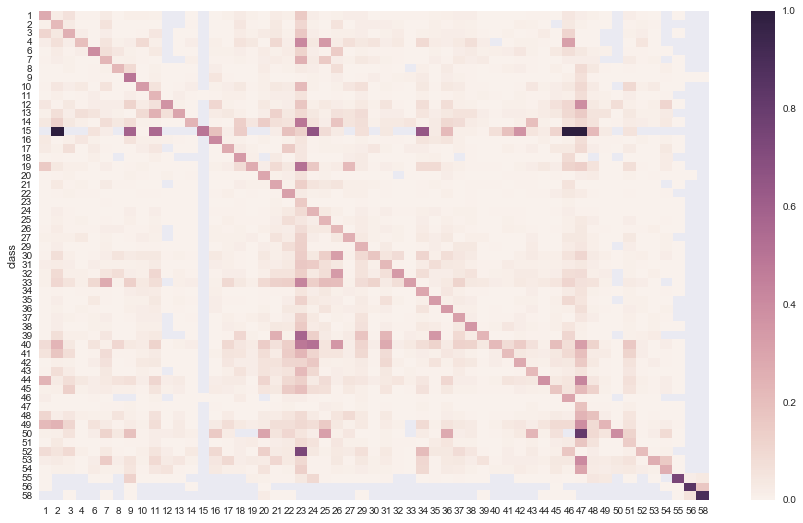

In [61]:
plt.figure(figsize=(15,9))
ax = seaborn.heatmap(cm_percent, vmin=0, vmax=1)

In [67]:
sel_ind = [[i,j] for i, j in zip(range(1,58), range(1,58))]

In [73]:
pd.Series(cm_percent.values.diagonal(), index=cm_percent.index).sort_values(ascending=False)

class
58    0.897977
56    0.845028
55    0.740215
15    0.496933
9     0.496886
16    0.411251
50    0.395308
6     0.391615
44    0.373455
12    0.369589
38    0.359188
18    0.341458
32    0.341235
36    0.340762
10    0.338827
35    0.333677
33    0.326251
22    0.315949
37    0.314572
13    0.301639
46    0.300347
20    0.292939
21    0.292311
34    0.290670
1     0.276289
42    0.273441
17    0.270432
19    0.266098
53    0.263820
54    0.263417
27    0.256007
3     0.255799
29    0.245500
14    0.241037
24    0.240843
39    0.237549
49    0.235490
11    0.233796
25    0.232590
7     0.226679
8     0.226477
26    0.225510
31    0.220945
2     0.218336
40    0.216774
43    0.212927
41    0.205779
52    0.204175
4     0.192415
48    0.188449
47    0.185922
30    0.171410
45    0.170086
23    0.153982
51    0.142560
dtype: float64

In [49]:
confusion_matrix.apply(lambda x: x.sort_values(ascending=False).index[1],axis=1)

class
1     23
10    23
11    47
12    12
13    11
14    14
15     2
16    47
17    22
18    46
19    19
2     23
20    23
21    23
22    46
23    46
24    23
25    22
26    23
27    23
29    23
3     23
30    30
31    23
32    26
33    33
34    47
35    23
36    47
37    23
38    23
39    35
4     25
40    23
41    41
42    24
43    43
44    44
45    23
46    18
47    25
48    48
49     2
50    50
51    51
52    34
53    53
54    54
55     9
56    58
58    56
6     26
7      7
8      9
9     47
dtype: object

In [50]:
confusion_matrix.apply(lambda x: x.sort_values(ascending=False).iat[1],axis=1)

class
1      6809.0
10     6189.0
11     4363.0
12     3014.0
13     2753.0
14     2212.0
15      286.0
16     2313.0
17     4237.0
18     4222.0
19     4120.0
2      6102.0
20     3062.0
21     9065.0
22     3737.0
23     2822.0
24     6873.0
25     5865.0
26     6029.0
27     4468.0
29     9449.0
3      6572.0
30     3132.0
31     7748.0
32     6523.0
33     3163.0
34     3395.0
35     5430.0
36     4232.0
37     6408.0
38     6625.0
39     4217.0
4      6200.0
40     4416.0
41     3447.0
42     3947.0
43     6348.0
44     6075.0
45     5291.0
46     2718.0
47     2675.0
48     7407.0
49     2855.0
50     1584.0
51     6102.0
52     2738.0
53     2706.0
54     4874.0
55      289.0
56      386.0
58      256.0
6      3807.0
7     10614.0
8      1737.0
9      3454.0
dtype: float64

In [47]:
confusion_matrix.idxmax()

1      1
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
2      2
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
29    29
3      3
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
4      4
40    40
41    41
42    42
43    43
44    44
45    45
46    46
47    47
48    48
49    49
50    50
51    51
52    52
53    53
54    54
55    55
56    56
58    58
6      6
7      7
8      8
9      9
dtype: object